# Multivariate timeseries forecasting with LSTMs in Keras

This notebook is based on the air pollution forecasting dataset collected in China by the US Embassy of Beijing.
Specifically, the notebook is taken from __[this Kaggle Kernel](https://www.kaggle.com/lokeshkumarn/timeseries-multivariate)__ and __[this blog post](https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/)__.

The dataset consists of the following columns:
* **No** row number
* **year** year of data in this row
* **month** month of data in this row
* **day** day of data in this row
* **hour** hour of data in this row
* **pm2.5** PM2.5 concentration
* **DEWP** Dew Point
* **TEMP** Temperature
* **PRES** Pressure
* **cbwd** Combined wind direction
* **Iws** Cumulated wind speed
* **Is** Cumulated hours of snow
* **Ir** Cumulated hours of rain

Given those variables, the goal is to forecast the pollution. The pm 2.5 is a proxy variable, being it an indicator of human activy, expecially related to a certain kind of combustion.

## 1. Downloading the dataset

In [10]:
!ls data/pollution/ || mkdir -p data/pollution

pollution.csv


In [11]:
!ls data/pollution/pollution.csv || wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv --directory-prefix=data/pollution

data/pollution/pollution.csv


In [12]:
ls data/pollution

pollution.csv


## 2. Exploring the dataset

In [13]:
import numpy as np
import pandas as pd
from datetime import datetime

import matplotlib
from matplotlib import pyplot as plt

In [14]:
# define a parser for the date to combine the fields in a datetime
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')

In [15]:
data = pd.read_csv('data/pollution/pollution.csv',index_col=0, date_parser=parse, parse_dates=[['year','month','day','hour']])
# drop the column number which is pointless
data.drop(columns=['No'], axis=1, inplace=True)

In [16]:
# rename columns
print(data.columns)
data.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
print(data.columns)

Index(['pm2.5', 'DEWP', 'TEMP', 'PRES', 'cbwd', 'Iws', 'Is', 'Ir'], dtype='object')
Index(['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow',
       'rain'],
      dtype='object')


In [17]:
print(data.index)
print(data.index.name)
# rename index
data.index.name='date'
print(data.index.name)

DatetimeIndex(['2010-01-01 00:00:00', '2010-01-01 01:00:00',
               '2010-01-01 02:00:00', '2010-01-01 03:00:00',
               '2010-01-01 04:00:00', '2010-01-01 05:00:00',
               '2010-01-01 06:00:00', '2010-01-01 07:00:00',
               '2010-01-01 08:00:00', '2010-01-01 09:00:00',
               ...
               '2014-12-31 14:00:00', '2014-12-31 15:00:00',
               '2014-12-31 16:00:00', '2014-12-31 17:00:00',
               '2014-12-31 18:00:00', '2014-12-31 19:00:00',
               '2014-12-31 20:00:00', '2014-12-31 21:00:00',
               '2014-12-31 22:00:00', '2014-12-31 23:00:00'],
              dtype='datetime64[ns]', name='year_month_day_hour', length=43824, freq=None)
year_month_day_hour
date


In [18]:
# mark all NA values of the target variable with 0
data['pollution'].fillna(0, inplace=True)

In [19]:
# drop the first 24 hours
data = data[24:]

In [20]:
# show data format
data.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [21]:
# show example summary of pre-processed data
data.describe()

,pollution,dew,temp,press,wnd_spd,snow,rain
count,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000
mean,94.013516,1.828516,12.459041,1016.447306,23.894307,0.052763,0.195023
std,92.252276,14.429326,12.193384,10.271411,50.022729,0.760582,1.416247
min,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,24.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,68.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,132.250000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


As visible, ***wnd_dir*** is excluded from the summary, since it is a categorical variable, specifically with elements of ***str*** types.

In [22]:
data["wnd_dir"].dtypes

dtype('O')

In [23]:
from pandas.api.types import is_numeric_dtype
numeric_columns = [c for c in data.columns if is_numeric_dtype(data[c])]

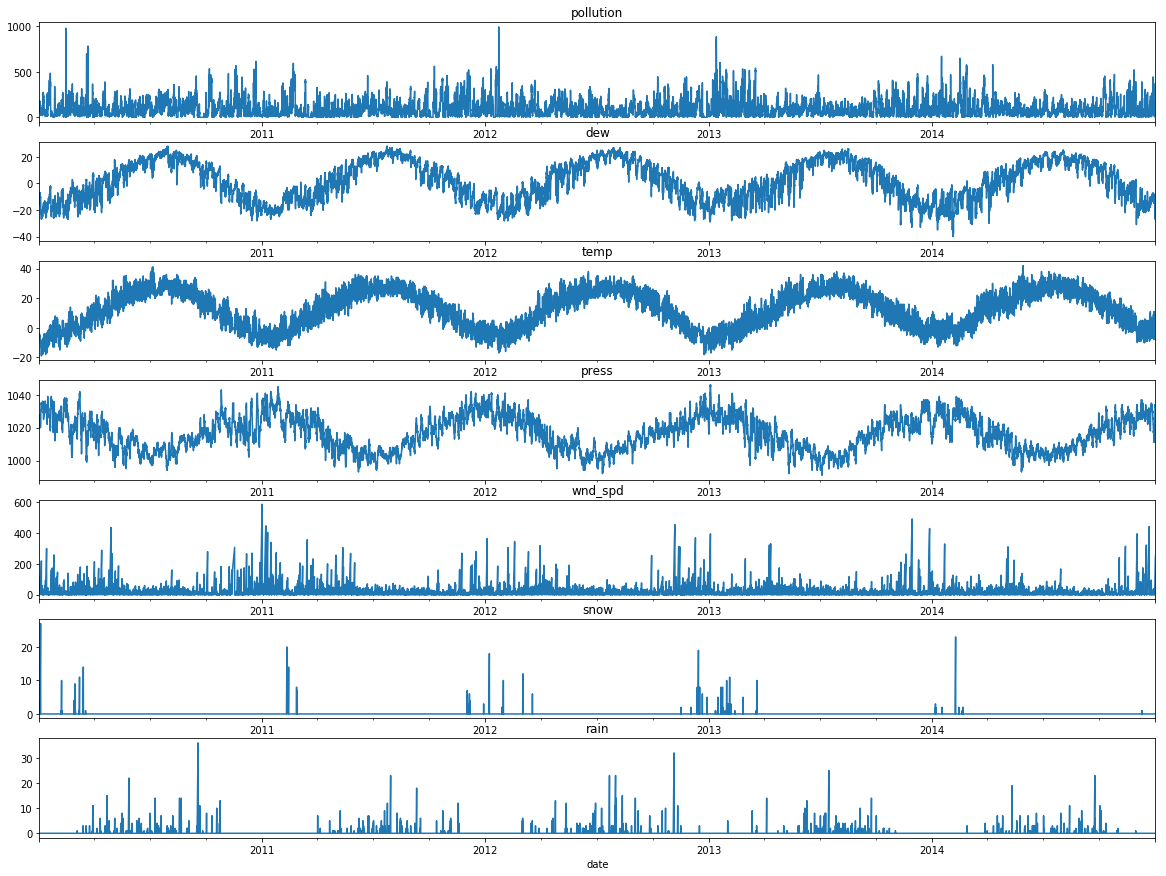

In [24]:
# plot each column except wnd_dir
fig,ax = plt.subplots(len(numeric_columns),1,figsize=(20,15))
for i, c in enumerate(numeric_columns):    
    data[c].plot(ax=ax[i])
    ax[i].set_title(c)

## 3. Data Preparation

In [25]:
values = data.values
values

array([[129.0, -16, -4.0, ..., 1.79, 0, 0],
       [148.0, -15, -4.0, ..., 2.68, 0, 0],
       [159.0, -11, -5.0, ..., 3.57, 0, 0],
       ...,
       [10.0, -22, -3.0, ..., 242.7, 0, 0],
       [8.0, -22, -4.0, ..., 246.72, 0, 0],
       [12.0, -21, -3.0, ..., 249.85, 0, 0]], dtype=object)

Encode the categorical variable ***wnd_dir***. This can be done either using one-hot encoding or an ordinal encoder (i.e., using an enumeration over classes).

In [26]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
encoder = LabelEncoder()
# the label encoder encode labels with value between 0 and n_classes-1

In [27]:
np.unique(values[:,4])

array(['NE', 'NW', 'SE', 'cv'], dtype=object)

In [28]:
values[:,4] = encoder.fit_transform(values[:,4])

In [29]:
encoder.classes_

array(['NE', 'NW', 'SE', 'cv'], dtype=object)

Now that we have all numerical values, we can convert all to float to use the same data type:

In [30]:
values = values.astype('float32')

Normalize the columns so that the values are all in the interval [0,1].

In [31]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

Time series forecasting is the problem by which a sequence of samples collected at [t, t-n] is used to forecast samples at [t+1, t+m]. Based on the size of **m** we can naturally distinguish in simple regression problems (e.g. closing day price for an auction) and actual sequence to sequence forecasting problems.

__[This blog post](https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/)__ uses pandas shift() function to create new columns of lagged observations, namely to be used as target variables for supervised time series prediction. For multivariate time series, the same concept can be applied to each of the channels to predict. This way, we have a function taking as input:
- ***data*** the raw data, as a 2-D array
- ***n_in*** the size of the lag to apply on the observations to produce the input sequence, which can be in [1, len(data)].
- ***n_out*** the size of the lag to apply on the observations to produce the forecasting window, which can be in [0, len(data)-1].
- ***dropnan*** whether to drop row entries with NaN values

In [32]:
# taken from https://www.kaggle.com/lokeshkumarn/timeseries-multivariate
# and https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
# and https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

For the input time serie, the function appends a column for each of the variables at each of the lag steps:
- a positive shift in range(n_in, 0, -1) means appending at the beginning of the serie a sequence of NaN values for the size of the lag (i.e. in this case 1 lag per step in the interval [n_in, 0); when performing a positive shift, we clearly add NaN or a specific default value in an operation that is called of padding. The dropna is used to remove those entries, since we would otherwise include erroneous data.
- a negative shift in range(0, n_out) (i.e., -0,...,-(nout-1)) means creating a sequence at t (original), as well as adding as new columns further sequences shifted in the future each of 1 element (i.e. at t+1, t+2, t+(nout-1)).

See __[the pandas shift documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shift.html)__ for further information.

In [33]:
# convert the dataset to a supervised learning problem, using lag 1 and forecast 1, wrt each of the input channels
reframed = series_to_supervised(scaled, 1, 1)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0
3,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0
4,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0
5,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658,0.485294,0.213115,0.563637,0.666667,0.011433,0.111111,0.0


In [34]:
# drop columns we don't want to predict, i.e. all except the pollution (pm2.5)
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960
3,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093
4,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833
5,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658


In [35]:
values = reframed.values

Split into train and test set:

In [36]:
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
print("train.shape", train.shape)
test = values[n_train_hours:, :]
print("test.shape", test.shape)

train.shape (8760, 9)
test.shape (35039, 9)


At this point we got *var1* to *var8* at time *t-1* being the observations, and *var1* at time *t* (the last column) being the target variable Y.

In [37]:
train_X, train_y = train[:, :-1], train[:, -1]
print("train", train_X.shape, train_y.shape)
test_X, test_y = test[:, :-1], test[:, -1]
print("test", test_X.shape, test_y.shape)

train (8760, 8) (8760,)
test (35039, 8) (35039,)


The input of an LSTM is a 3-dimensional tuple, which includes:
- **samples** - one time serie is a sample, multiple samples constitute a batch to be used for a training epoch
- **time steps** - a time step is a measurement inside a specific time serie or sequence, so timesteps defines the window lenght for our time serie
- **features** - the number of channels, i.e. the time serie is univariate or multivariate

Please check __[this blog post](https://machinelearningmastery.com/reshape-input-data-long-short-term-memory-networks-keras/)__ for a further explanation.

Reshape to a 3D format that is appropriate for the Keras ANN input shape we are going to select:

In [38]:
# reshape input to be 3D [batch_size, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)


This means, that the X set is of kind (number of rows, 1 time step or measurement, 8 channels or features) while the Y set is of kind (number of rows, 1 time step, 1 target variable). Using a time step of size 1 does not really exploits the power of the time series data, but it is certainly a lot easier to handle.

## 4. Model definition

In [39]:
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, Softmax, Add, Flatten, Activation, Dropout, LSTM, GRU
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from livelossplot import PlotLossesKeras
from keras.regularizers import l1, l2, l1_l2

Using TensorFlow backend.


In [40]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.85
set_session(tf.Session(config=config))

In [41]:
def get_model():
    model = Sequential()
    model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    return model

In [42]:
# raw keras
#from livelossplot.keras import PlotLossesCallback
# tensorflow.keras
from livelossplot.tf_keras import PlotLossesCallback
plot_losses = PlotLossesCallback()

In [43]:
# https://machinelearningmastery.com/reproducible-results-neural-networks-keras/
from numpy.random import seed
seed(12345)
from tensorflow import set_random_seed
set_random_seed(12345)

In [44]:
model = get_model()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                11800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 11,851
Trainable params: 11,851
Non-trainable params: 0
_________________________________________________________________


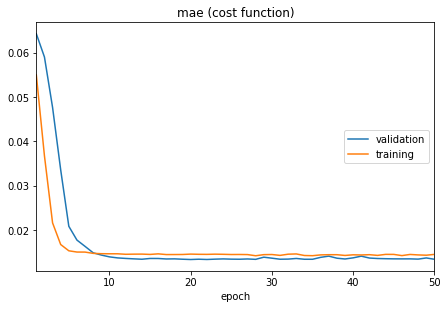

mae (cost function):
validation (min:    0.013, max:    0.064, cur:    0.013)
training   (min:    0.014, max:    0.055, cur:    0.015)


In [45]:
# fit network
history = model.fit(train_X,
                    train_y,
                    epochs=50,
                    batch_size=72,
                    validation_data=(test_X, test_y),
                    verbose=2,
                    shuffle=False,
                    callbacks=[plot_losses])

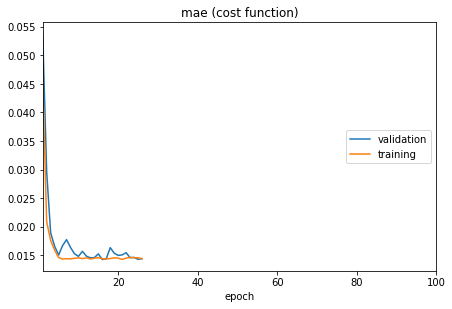

mae (cost function):
validation (min:    0.014, max:    0.054, cur:    0.014)
training   (min:    0.014, max:    0.045, cur:    0.014)


In [46]:
from keras.callbacks import EarlyStopping
stop_noimprovement = EarlyStopping(patience=10)

# restart from clean model (no weights of previous training)
model = get_model()

history= model.fit(train_X,
                   train_y,
                   validation_data=(test_X, test_y),
                   epochs=100,
                   verbose=2,
                   shuffle=False,
                   callbacks=[stop_noimprovement, plot_losses])

## 5. Prediction

In [47]:
from numpy import concatenate
# make a prediction
predicted = model.predict(test_X)
print(predicted.shape)

(35039, 1)


In [48]:
testXRe = test_X.reshape((test_X.shape[0], test_X.shape[2]))
print(testXRe.shape)

(35039, 8)


In [49]:
predicted = np.concatenate((predicted, testXRe[:, 1:]), axis=1)
print(predicted.shape)

(35039, 8)


In [50]:
# invert scaling for forecast
predicted = scaler.inverse_transform(predicted)
predicted = predicted[:,0]
print(predicted.shape)

(35039,)


In [51]:
test_y = test_y.reshape((len(test_y), 1))
print(test_y.shape)

(35039, 1)


In [52]:
# invert scaling for actual
inv_y = concatenate((test_y, testXRe[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

Calculate the RMSE between the 2 arrays, i.e. actual Y and predicted Y:

In [53]:
from math import sqrt
from sklearn.metrics import mean_squared_error

rmse = sqrt(mean_squared_error(inv_y, predicted))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 27.406


## 6. Ensemble-based modeling

As an example of an alternative method, let's check how to model the same problem using a tree-ensemble. 
To start, let's reset train and test to the raw features (without scaling applied):

In [54]:
train_X, train_y = train[:, :-1], train[:, -1]
print("train", train_X.shape, train_y.shape)
test_X, test_y = test[:, :-1], test[:, -1]
print("test", test_X.shape, test_y.shape)

train (8760, 8) (8760,)
test (35039, 8) (35039,)


Let's use a xgboos regressor for the problem, since we are basically treating the time serie as tabular data:

In [55]:
from xgboost import XGBRegressor
xgb_model = XGBRegressor(objective='reg:linear', n_jobs=8, nthread=8, seed=1234, scoring='roc_auc')
# see also https://www.kaggle.com/stuarthallows/using-xgboost-with-scikit-learn

In [56]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
reg_cv = GridSearchCV(xgb_model, {"learning_rate" : [0.1, 0.2, 0.4],
                                  "colsample_bytree":[0.8, 1.0],
                                  "min_child_weight":[1.0, 1.2], 
                                  'max_depth': [3,4,6], 
                                  'n_estimators': [500,1000]
                                  },
                      verbose=1)

In [57]:
reg_cv.fit(train_X, train_y)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=1)]: Done 216 out of 216 | elapsed:  1.7min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=8,
       nthread=8, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, scoring='roc_auc', seed=1234,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'min_child_weight': [1.0, 1.2], 'colsample_bytree': [0.8, 1.0], 'max_depth': [3, 4, 6], 'learning_rate': [0.1, 0.2, 0.4], 'n_estimators': [500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [58]:
print(reg_cv.best_params_)
print(reg_cv.best_score_)

{'min_child_weight': 1.2, 'colsample_bytree': 0.8, 'max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 500}
0.7715467821638474


Train the model using the best hyperparameters found by the Grid Search step:

In [59]:
xgb_model = XGBRegressor(**reg_cv.best_params_)
xgb_model.fit(train_X, train_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1.2, missing=None, n_estimators=500, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [60]:
print(dir(xgb_model))

['_Booster', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_estimator_type', '_get_param_names', 'apply', 'base_score', 'booster', 'coef_', 'colsample_bylevel', 'colsample_bytree', 'evals_result', 'feature_importances_', 'fit', 'gamma', 'get_booster', 'get_params', 'get_xgb_params', 'importance_type', 'intercept_', 'kwargs', 'learning_rate', 'load_model', 'max_delta_step', 'max_depth', 'min_child_weight', 'missing', 'n_estimators', 'n_jobs', 'nthread', 'objective', 'predict', 'random_state', 'reg_alpha', 'reg_lambda', 'save_model', 'scale_pos_weight', 'score', 'seed', 'set_params', 'silent', 'subsample']


We can check the importance of each of the features being used:

In [61]:
xgb_model.feature_importances_

array([0.73935026, 0.04947759, 0.03276362, 0.03558873, 0.07665501,
       0.05099297, 0.00258155, 0.01259028], dtype=float32)

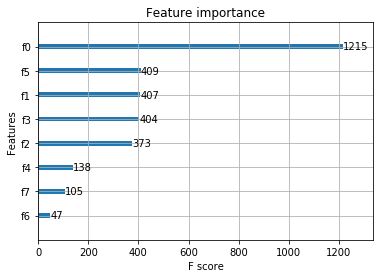

In [62]:
import xgboost as xgb
xgb.plot_importance(xgb_model)

Clearly, the most support is over the same variable PM 2.5 at t-1, since there are dependencies over time on the same variable that drive prediction, and could potentially lead to model overfitting.

In [63]:
y_pred = xgb_model.predict(test_X)
y_pred

array([0.03365326, 0.03235629, 0.02351913, ..., 0.01179025, 0.01179025,
       0.01045564], dtype=float32)

Get the selected score:

In [64]:
xgb_model.score(test_X, test_y)

0.8891146844189279

In [65]:
from math import sqrt
from sklearn.metrics import mean_squared_error
rmse = sqrt(mean_squared_error(test_y, y_pred))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.031


## 7. AutoML based regression model

In [66]:
# https://automl.github.io/auto-sklearn/stable/examples/example_regression.html
import autosklearn.regression

In [67]:
automl = autosklearn.regression.AutoSklearnRegressor(
    time_left_for_this_task=120,
    per_run_time_limit=30,
    tmp_folder='data/pollution/tmp/autosklearn_tmp',
    output_folder='data/pollution/tmp/autosklearn_out',
)

In [72]:
train_X.shape

(8760, 8)

We got 8 numerical features, since we previously converted them, we may try in future to leave them untouched (raw):

In [73]:
#feature_types = (['numerical'] * 3) + ['categorical'] + (['numerical'] * 9)
feature_types = (['numerical'] * 8)

In [74]:
automl.fit(train_X, train_y, dataset_name='pollution', feat_type=feature_types)

/usr/local/lib/python3.5/dist-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-04-19 15:33:24,120:AutoMLSMBO(1)::pollution] Could not find meta-data directory /usr/local/lib/python3.5/dist-packages/autosklearn/metalearning/files/r2_regression_dense
[WARNING] [2019-04-19 15:33:24,135:EnsembleBuilder(1):pollution] No models better than random - using Dummy Score!
[WARNING] [2019-04-19 15:33:24,147:EnsembleBuilder(1):pollution] No models better than random - using Dummy Score!


/usr/local/lib/python3.5/dist-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-04-19 15:33:26,150:EnsembleBuilder(1):pollution] No models better than random - using Dummy Score!


/usr/local/lib/python3.5/dist-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/usr/local/lib/python3.5/dist-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/usr/local/lib/python3.5/dist-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/usr/local/lib/python3.5/dist-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/usr/local/lib/python3.5/dist-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/usr/local/lib/python3.5/dist-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty

AutoSklearnRegressor(delete_output_folder_after_terminate=True,
           delete_tmp_folder_after_terminate=True,
           disable_evaluator_output=False, ensemble_memory_limit=1024,
           ensemble_nbest=50, ensemble_size=50, exclude_estimators=None,
           exclude_preprocessors=None, get_smac_object_callback=None,
           include_estimators=None, include_preprocessors=None,
           initial_configurations_via_metalearning=25, logging_config=None,
           metadata_directory=None, ml_memory_limit=3072, n_jobs=None,
           output_folder='data/pollution/tmp/autosklearn_out',
           per_run_time_limit=30, resampling_strategy='holdout',
           resampling_strategy_arguments=None, seed=1, shared_mode=False,
           smac_scenario_args=None, time_left_for_this_task=120,
           tmp_folder='data/pollution/tmp/autosklearn_tmp')

In [75]:
print(automl.show_models())

[(0.540000, SimpleRegressionPipeline({'regressor:random_forest:max_features': 0.8393500859980979, 'regressor:random_forest:min_impurity_decrease': 0.0, 'regressor:random_forest:criterion': 'friedman_mse', 'regressor:random_forest:max_depth': 'None', 'categorical_encoding:__choice__': 'one_hot_encoding', 'categorical_encoding:one_hot_encoding:use_minimum_fraction': 'False', 'regressor:__choice__': 'random_forest', 'regressor:random_forest:min_samples_split': 6, 'regressor:random_forest:max_leaf_nodes': 'None', 'regressor:random_forest:min_weight_fraction_leaf': 0.0, 'preprocessor:__choice__': 'no_preprocessing', 'regressor:random_forest:min_samples_leaf': 10, 'rescaling:__choice__': 'standardize', 'regressor:random_forest:n_estimators': 100, 'regressor:random_forest:bootstrap': 'True', 'imputation:strategy': 'median'},
dataset_properties={
  'sparse': False,
  'task': 4,
  'target_type': 'regression',
  'multiclass': False,
  'signed': False,
  'multilabel': False})),
(0.300000, SimpleR

In [78]:
predictions = automl.predict(test_X)

In [79]:
print("R2 score:", sklearn.metrics.r2_score(test_y, predictions))

R2 score: 0.9118508034736534


In [83]:
print("mse:", sklearn.metrics.mean_squared_error(test_y, predictions))

mse: 0.0007565229631973169


In [88]:
print(
    dir(sklearn.metrics)
)

['SCORERS', '__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'accuracy_score', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'auc', 'average_precision_score', 'base', 'brier_score_loss', 'calinski_harabaz_score', 'classification', 'classification_report', 'cluster', 'cohen_kappa_score', 'completeness_score', 'confusion_matrix', 'consensus_score', 'coverage_error', 'euclidean_distances', 'explained_variance_score', 'f1_score', 'fbeta_score', 'fowlkes_mallows_score', 'get_scorer', 'hamming_loss', 'hinge_loss', 'homogeneity_completeness_v_measure', 'homogeneity_score', 'jaccard_similarity_score', 'label_ranking_average_precision_score', 'label_ranking_loss', 'log_loss', 'make_scorer', 'matthews_corrcoef', 'mean_absolute_error', 'mean_squared_error', 'mean_squared_log_error', 'median_absolute_error', 'mutual_info_score', 'normalized_mutual_info_score', 'pairwise', 'pairwise_distances', 'pairwise_distance